# Leaf Disease Classification

## Tomato Leaf Disease classification Model Training

### Import all the Dependencies

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

### Set all the Constants

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3  # denotes the number of color channels in the image
EPOCHS=30

### Reading and Generating the Train, Test and Validation data using ImageDataGenerator

##### We will use ImageDataGenerator api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory('DataSets/Tomato/train', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=32,
                                                   class_mode="sparse")
   

Found 11203 images belonging to 10 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory('DataSets/Tomato/val', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=32,
                                                   class_mode="sparse")

Found 2397 images belonging to 10 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, horizontal_flip=True)
test_generator = test_datagen.flow_from_directory('DataSets/Tomato/test', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=32,
                                                   class_mode="sparse")

Found 2411 images belonging to 10 classes.


### Knowing the DataStructure

In [46]:
total_samples = train_generator.n
batch_size = train_generator.batch_size

print(f'The train_generator consists {total_samples} image data with their labels.' )
print(f'The {total_samples} images are stored in batches of size {batch_size}.')

# Calculate the number of batches
num_batches_train = total_samples // batch_size

# If there are remaining samples that don't complete a full batch, add one more batch
if total_samples % batch_size != 0:
    num_batches_train += 1

print("Total number of batches in train_generator:", num_batches_train)

The train_generator consists 11203 image data with their labels.
The 11203 images are stored in batches of size 32.
Total number of batches in train_generator: 351


In [47]:
# Lets Load a batch and explore it
batch = train_generator.next()
print(f'The batch consists of {len(batch)} elements a images_batch and a labels_batch of 32 samples max:' )
print('-'*108)
print('The batch size is 32 and image shape is 256*256 in rbg format(3):\n', batch[0].shape)
print()
print('The labels of 32 images in a batch are :\n', batch[1])

The batch consists of 2 elements a images_batch and a labels_batch of 32 samples max:
------------------------------------------------------------------------------------------------------------
The batch size is 32 and image shape is 256*256 in rbg format(3):
 (32, 256, 256, 3)

The labels of 32 images in a batch are :
 [4. 7. 8. 2. 0. 7. 9. 5. 3. 0. 6. 4. 0. 4. 9. 6. 7. 1. 3. 4. 4. 1. 9. 6.
 2. 7. 4. 5. 0. 4. 2. 5.]


In [48]:
classes = list(train_generator.class_indices.keys())
print(f'Number of classes {len(classes)}')
print(classes)

Number of classes 10
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [14]:
class_names = ['Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two spotted spider mite', 'Tomato Target Spot', 'Tomato Tomato_YellowLeaf Curl Virus', 'Tomato Tomato mosaic virus', 'Tomato healthy']

(-0.5, 255.5, 255.5, -0.5)

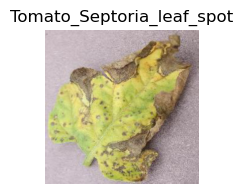

In [50]:
images_batch, labels_batch = batch
image1 = images_batch[0]
label1 = labels_batch[0]

plt.figure(figsize=(2, 2))
plt.imshow(image1)
plt.title(classes[int(label1)])
plt.axis('off') 

## Building the Model

### Model Architecture
1. We use a CNN coupled with a `softmax` activation in the output layer. 
2. Use `train_generator`, `validation_generator` to resize and scale data; and also generate augmented data

In [51]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),  # Adding dropout with a rate (adjust rate as needed)
    layers.Dense(n_classes, activation='softmax'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 62, 62, 64)        16448     
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 64)      

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

* Use `SparseCategoricalCrossentropy` when your target labels are integers (class indices).
* Use `CategoricalCrossentropy` when your target labels are one-hot encoded vectors.

In [52]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [53]:
# steps_per_epoch = total_samples / batch_size 
num_batches_train  # we already calculated above

351

In [54]:
# For validation_steps  (total_samples / batch_size)

num_batches_val = validation_generator.n // validation_generator.batch_size
if total_samples % batch_size != 0: # If there are remaining samples that don't complete a full batch, add one more batch
    num_batches_val += 1
    
num_batches_val

75

In [55]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)


# Convert to a dictionary to be used in model.fit
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.7528897849462366,
 1: 1.6004285714285715,
 2: 0.8385479041916167,
 3: 1.682132132132132,
 4: 0.9041969330104923,
 5: 0.9550724637681159,
 6: 1.1408350305498982,
 7: 0.49902004454342985,
 8: 4.292337164750958,
 9: 1.0065588499550764}

In [56]:
history = model.fit(
    train_generator,
    steps_per_epoch=351,  # num_batches_train
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=75,  # num_batches_val
    verbose=1,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

Epoch 1/30
351/351 [==============================] - 319s 906ms/step - loss: 1.8949 - accuracy: 0.3231 - val_loss: 1.3002 - val_accuracy: 0.5386
Epoch 2/30
351/351 [==============================] - 312s 889ms/step - loss: 1.2530 - accuracy: 0.5673 - val_loss: 0.9222 - val_accuracy: 0.6813
Epoch 3/30
351/351 [==============================] - 310s 884ms/step - loss: 0.8924 - accuracy: 0.7062 - val_loss: 0.7166 - val_accuracy: 0.7455
Epoch 4/30
351/351 [==============================] - 308s 876ms/step - loss: 0.6791 - accuracy: 0.7791 - val_loss: 0.5065 - val_accuracy: 0.8277
Epoch 5/30
351/351 [==============================] - 308s 877ms/step - loss: 0.5309 - accuracy: 0.8244 - val_loss: 0.4871 - val_accuracy: 0.8365
Epoch 6/30
351/351 [==============================] - 287s 817ms/step - loss: 0.4875 - accuracy: 0.8357 - val_loss: 0.4246 - val_accuracy: 0.8523
Epoch 7/30
351/351 [==============================] - 288s 820ms/step - loss: 0.4396 - accuracy: 0.8556 - val_loss: 0.4888 -

In [57]:
scores = model.evaluate(test_generator)

76/76 [==============================] - 32s 423ms/step - loss: 0.1811 - accuracy: 0.9423


**You can see above that we get 95% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [58]:
scores

[0.18109385669231415, 0.9423475861549377]

Scores is just a list containing loss and accuracy value

## Confusion Matrix

In [59]:
print(f'{test_generator.n} Images in {round(test_generator.n/32)} batches with batch size {32}')

2411 Images in 75 batches with batch size 32


In [60]:
true_y = []
pred_y = []

# Iteratig over test_generator for true labels and predictions for the entire test set
for i in range(len(test_generator)):
    test_batch = test_generator.next()
    
    true_classes = test_batch[1]
    true_y.extend([class_names[int(label)] for label in true_classes])

    batch_predictions = model.predict(test_batch[0],verbose=False)
    pred_classes = [np.argmax(pred) for pred in batch_predictions]
    pred_y.extend([class_names[pred] for pred in pred_classes])

    
# Confusion Matrix and classification report
cfm = confusion_matrix(true_y,pred_y)  
print("Confusion Matrix:\n")
print(cfm)
print('-'*108)

report = classification_report(true_y, pred_y, target_names=class_names)
print("Classification Report:\n",report)

Confusion Matrix:

[[315   5   0   0   0   0   0   0   0   0]
 [  5 142   1   0   1   0   0   0   1   0]
 [  3  27 248   6   2   0   0   0   0   1]
 [  0   0   0 142   0   1   0   0   0   1]
 [  3   9   0  10 244   0   0   1   0   0]
 [  0   0   0   3   0 238  11   0   0   0]
 [  7   1   0   1   7   4 190   1   0   1]
 [  0   0   0   0   0   0   1  56   0   0]
 [ 19   3   1   2   0   1   0   0 456   0]
 [  0   0   0   0   0   2   1   0   0 237]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                                              precision    recall  f1-score   support

                      Tomato Bacterial spot       0.89      0.98      0.94       320
                        Tomato Early blight       0.76      0.95      0.84       150
                         Tomato Late blight       0.99      0.86      0.92       287
                           Tomato Leaf Mold       0.87      0.99      0.92  

### Plotting the Accuracy and Loss Curves

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [61]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 351}

In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val_loss, val_accuracy etc are a python list containing values of loss, accuracy etc at the end of each epoch.**
#### History stores all the Lists in a dictionary format

In [63]:
type(history.history['loss'])

list

In [64]:
len(history.history['loss'])

30

In [65]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.8948917388916016,
 1.252967119216919,
 0.8923704028129578,
 0.6790883541107178,
 0.5308516025543213]

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

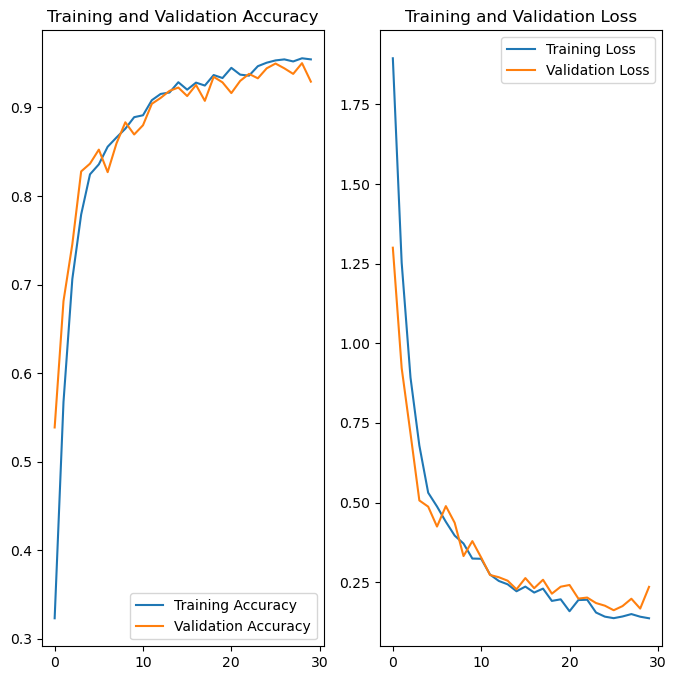

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write a function for inference

In [68]:
from tensorflow.keras.preprocessing import image as keras_image

def predict(model, class_names, img):
    # Preprocess the image
    target_size = (256, 256)  # Replace with your desired target size
    img = keras_image.array_to_img(img)
    resized_img = img.resize(target_size)
    resized_img_array = keras_image.img_to_array(resized_img)
    resized_img_array = np.expand_dims(resized_img_array, axis=0)  # Add batch dimension
    preprocessed_img = resized_img_array / 255.0  # Normalize pixel values
    
    # Make prediction
    predictions = model.predict(x=preprocessed_img,verbose=0)
    
    # Get predicted class and confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

In [69]:
class_names = ['Tomato Bacterial spot', 'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold', 'Tomato Septoria leaf spot', 'Tomato Spider mites Two spotted spider mite', 'Tomato Target Spot', 'Tomato Tomato_YellowLeaf Curl Virus', 'Tomato Tomato mosaic virus', 'Tomato healthy']

##### Run prediction on a sample image

In [70]:
test_batch = test_generator.next()
test_images, test_labels = test_batch

In [71]:
predict(model, class_names=class_names, img=test_images[0])

('Tomato Tomato_YellowLeaf Curl Virus', 91.14)

**Now run inference on few sample images**

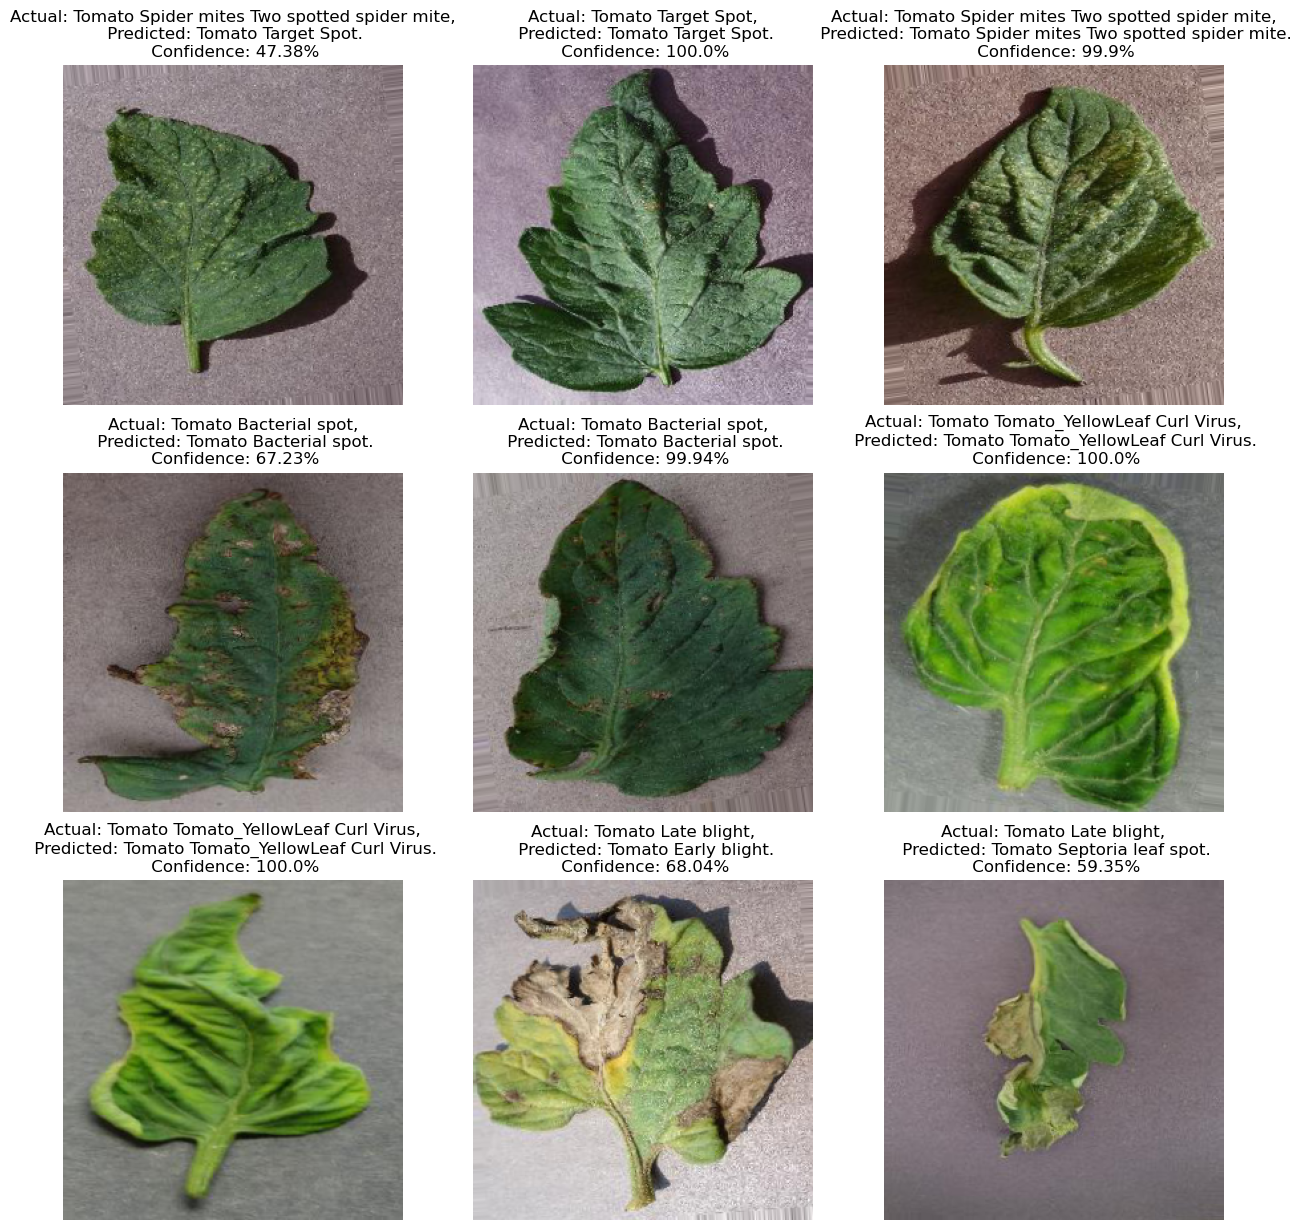

In [72]:
plt.figure(figsize=(15, 15))

# Number of images to display
num_images = 9
images_displayed = 0  # Counter to track displayed images

# Read and display images
for _ in range(num_images):
    test_batch = test_generator.next()
    for i in range(len(test_batch[0])):
        test_image = test_batch[0][i]  # Accessing the image
        
        ax = plt.subplot(3, 3, i + 1)   # 9 images displaying into 3*3 subplot
        plt.imshow(test_image)
        
        predicted_class, confidence = predict(model,class_names, test_image)
        actual_class = class_names[int(test_batch[1][i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')  # Remove axis from image
        
        images_displayed += 1
        if images_displayed >= num_images: # Conditions to break the loop
            break
    if images_displayed >= num_images:
        break

### Saving the Model and its INFO according to your versions

In [73]:
# import os,json

# model_folder = "saved_models/TomatoLeaf/Version2"
# model_name = "TomatoLeaf_model(95%-30e).h5"

In [74]:
# #Saving model and its history in 
# os.makedirs(model_folder,exist_ok=True)
# model.save(os.path.join(model_folder,model_name))

# history_dict=history.history
# with open(os.path.join(model_folder, 'history.json'), 'w') as json_file:
#     json.dump(history_dict, json_file)
    
# with open(os.path.join(model_folder, 'classification_report.txt'), 'w') as file:
#     file.write(report)

In [ ]:
loaded_model = load_model(r"saved_models/TomatoLeaf/Version2/TomatoLeaf_model-30EPOCHS(95.8%).h5")

### on test data

In [16]:
true_y = []
pred_y = []
# Version2/TomatoLeaf_model-30EPOCHS(95.8%)
# Iteratig over test_generator for true labels and predictions for the entire test set
for i in range(len(test_generator)):
    test_batch = test_generator.next()
    
    true_classes = test_batch[1]
    true_y.extend([class_names[int(label)] for label in true_classes])

    batch_predictions = loaded_model.predict(test_batch[0],verbose=False)
    pred_classes = [np.argmax(pred) for pred in batch_predictions]
    pred_y.extend([class_names[pred] for pred in pred_classes])

    
# Confusion Matrix and classification report
cfm = confusion_matrix(true_y,pred_y)  
print("Confusion Matrix:\n")
print(cfm)
print('-'*108)

report = classification_report(true_y, pred_y, target_names=class_names)
print("Classification Report:\n",report)

Confusion Matrix:

[[302  14   1   0   2   0   0   0   1   0]
 [  0 141   5   0   2   0   1   0   1   0]
 [  0  19 263   3   1   0   0   0   0   1]
 [  0   0   1 141   1   0   0   0   1   0]
 [  0   3   2   7 254   0   0   1   0   0]
 [  0   0   0   1   0 238  11   2   0   0]
 [  1   3   0   0   4   3 200   1   0   0]
 [  0   0   0   0   0   0   0  57   0   0]
 [  1   2   0   0   0   1   0   0 478   0]
 [  0   0   0   0   0   1   2   0   0 237]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                                              precision    recall  f1-score   support

                      Tomato Bacterial spot       0.99      0.94      0.97       320
                        Tomato Early blight       0.77      0.94      0.85       150
                         Tomato Late blight       0.97      0.92      0.94       287
                           Tomato Leaf Mold       0.93      0.98      0.95  

### on train data

In [15]:
true_y = []
pred_y = []

# Iteratig over train_generator for true labels and predictions for the entire train set
for i in range(len(train_generator)):
    train_batch = train_generator.next()
    
    true_classes = train_batch[1]
    true_y.extend([class_names[int(label)] for label in true_classes])

    batch_predictions = loaded_model.predict(train_batch[0],verbose=False)
    pred_classes = [np.argmax(pred) for pred in batch_predictions]
    pred_y.extend([class_names[pred] for pred in pred_classes])

    
# Confusion Matrix and classification report
cfm = confusion_matrix(true_y,pred_y)  
print("Confusion Matrix:\n")
print(cfm)
print('-'*108)

report = classification_report(true_y, pred_y, target_names=class_names)
print("Classification Report:\n",report)

Confusion Matrix:

[[1441   32    1    0    6    0    3    0    5    0]
 [   0  678   11    0    3    0    6    1    1    0]
 [   4   32 1287    3    4    1    1    0    0    4]
 [   0    1    0  662    2    0    1    0    0    0]
 [   2    9    3    4 1218    0    2    0    1    0]
 [   0    3    0    1    0 1120   34   12    3    0]
 [   2    7    1    0    4    4  963    1    0    0]
 [   0    0    0    0    0    0    0  261    0    0]
 [   2    8    0    1    0    1    0    0 2233    0]
 [   0    0    0    0    0    1    4    0    0 1108]]
------------------------------------------------------------------------------------------------------------
Classification Report:
                                              precision    recall  f1-score   support

                      Tomato Bacterial spot       0.99      0.97      0.98      1488
                        Tomato Early blight       0.88      0.97      0.92       700
                         Tomato Late blight       0.99      0